In [44]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy import time
import pandas as pd

%matplotlib notebook

In [45]:
# Binary parameters (Zuniga-Fernandez et al. 2021)
t_ref = time.Time(2023, format='decimalyear').mjd   # t_ref = T0_AB 

e_B = 0.805
i_B = -np.radians(66.3)
a_B = 1.01
m_Ba = 0.77
m_Bb = 0.62
omega_Ba = np.radians(104.5)
omega_Bb = omega_Ba - np.pi
Omega_B = np.radians(342.7)+np.pi/2
T0_B = 48707.5
P_B = 314.86
mean_B = (2*np.pi*((t_ref - T0_B)/P_B))%(2*np.pi)

e_A = 0.4808
i_A = -np.radians(135.6)
a_A = 0.86
m_Aa = 0.93
m_Ab = 0.29
omega_Aa = np.radians(68.7)
omega_Ab = omega_Aa - np.pi
Omega_A = np.radians(170.2)+np.pi/2
T0_A = 48742.5
P_A = 264.51
mean_A = (2*np.pi*((t_ref - T0_A)/P_A))%(2*np.pi)

e_AB = 0.46
i_AB = -np.radians(88.1)
a_AB = 51
m_A = 1.22
m_B = 1.4
omega_A = np.radians(65)
omega_B = omega_A - np.pi
Omega_AB = np.radians(184.5)+np.pi/2
T0_AB = 2023
P_AB = 230
mean_AB = 0


# Disk parameters (Kennedy et al. 2019)
a_inner = 2.5
a_outer = 4.6
e_disk = 0.03
pos_disk = np.radians(15.6)
inc_disk = np.radians(26)
omega_disk = np.radians(-73)
b_inner = a_inner*np.cos(inc_disk)*(1-e_disk**2)**0.5
b_outer = a_outer*np.cos(inc_disk)*(1-e_disk**2)**0.5


In [46]:
def convmf(m_in, e_in):
    """Convert array of mean to true anomaly (for single e).
        
    From Vallado
    
    .. todo: tidy and include other orbit cases
    """
    
    m = np.array(m_in % (2. * np.pi))
    numiter = 50
    small = 0.00000001
    if e_in > small:
        
        ecc = np.array(e_in * 1.0)
        
        #       ;; /* ------------  initial guess ------------- */
        e0 = np.array(m + ecc)
        lo = np.logical_or( (m < 0.0) & (m > -np.pi), m > np.pi)
        e0[lo] = m[lo] - ecc
        
        ktr = 1
        e1  = np.array(e0 + (m - e0 + ecc * np.sin(e0)) / (1.0 - ecc * np.cos(e0)))
        while (np.max(np.abs(e1 - e0)) > small) & (ktr <= numiter):
            ktr += 1
            do = np.abs(e1 - e0) > small
            e0[do] = e1[do]
            e1[do] = e0[do] + (m[do] - e0[do] + ecc * np.sin(e0[do])) / (1.0 - ecc * np.cos(e0[do]))
        
        #       ;; /* ---------  find true anomaly  ----------- */
        sinv = (np.sqrt(1.0 - ecc * ecc) * np.sin(e1)) / (1.0-ecc * np.cos(e1))
        cosv = (np.cos(e1) - ecc) / (1.0 - ecc * np.cos(e1))
        nu   = np.arctan2( sinv, cosv)
    
    else:
        #       ;; /* --------------------- circular --------------------- */
        ktr = 0
        nu  = m
        e0  = m

    if ktr > numiter:
        print('WARNING: convmf did not converge')
    
    return nu

anom_A = convmf(mean_A, e_A)
anom_B = convmf(mean_B, e_B)
anom_AB  = convmf(mean_AB, e_AB)


In [47]:
print(np.degrees(anom_A))
print(np.degrees(anom_B))
print(np.degrees(anom_AB))

157.706322184098
-166.60030265538973
2.903104364469517e-31


In [48]:
# Create system B (Ba + Bb)

sim = rebound.Simulation()
sim.units = ('days', 'AU', 'Msun')


Ba = rebound.Particle(simulation=sim,
                      m=m_Ba,
                     )


Bb = rebound.Particle(simulation=sim,
                      primary=Ba,
                      m=m_Bb,
                      a=a_B,
                      e=e_B,
                      omega=omega_Bb,
                      inc=i_B,
                      Omega=Omega_B,
                      f=anom_B
                     )


sim.add(Ba)
sim.add(Bb)
sim.move_to_com()
Ba, Bb = sim.particles


# Create AaAb as a single object representing the CoM of AaAb relative to the CoM of BaBb

A = rebound.Particle(simulation=sim,
                     m=m_A,
                     a=a_AB,
                     e=e_AB,
                     omega=omega_A,
                     inc=i_AB,
                     Omega=Omega_AB,
                     f=anom_AB
                    )

# Create system AaAb and shift to CoM reference frame

sim_A = rebound.Simulation()
sim_A.units = ('days', 'AU', 'Msun')


Ab = rebound.Particle(simulation=sim_A,
                      m=m_Ab,
                     )

Aa = rebound.Particle(simulation=sim_A,
                      primary=Ab,
                      m=m_Aa,
                      a=a_A,
                      e=e_A,
                      omega=omega_Aa,
                      inc=i_A,
                      Omega=Omega_A,
                      f=anom_A
                     )


sim_A.add(Aa)
sim_A.add(Ab)
sim_A.move_to_com()
Aa_A, Ab_A = sim_A.particles      # Aa and Ab in the A CoM reference frame


# Shift Aa and Ab into the system B CoM reference frame

def change_reference_frames(star, ref):
    # ref = old reference frame in the new reference frame
    # star = star in the old reference frame
    ref_v = np.array([ref.vx, ref.vy, ref.vz])                            # velocity of current reference frame in the new reference frame
    v_in_ref = np.array([star.vx, star.vy, star.vz])                      # velocity of star in current reference frame
    v = v_in_ref + ref_v                                                  # velocity of star in the new reference frame
    
    ref_pos = np.array([ref.x, ref.y, ref.z])                             # position of current reference frame in the new reference frame
    pos_in_ref = np.array([star.x, star.y, star.z])                       # position of star in current reference frame
    pos = pos_in_ref + ref_pos                                            # position of star in the new reference frame
    
    return pos,v

pos_Aa, v_Aa = change_reference_frames(Aa_A, A)
pos_Ab, v_Ab = change_reference_frames(Ab_A, A)

def generate_cartesian_particle(m, pos, v):
    x, y, z = pos
    vx, vy, vz = v
    return rebound.Particle(m=m, x=x, y=y, z=z, vx=vx, vy=vy, vz=vz)

Aa = generate_cartesian_particle(m_Aa, pos_Aa, v_Aa)
Ab = generate_cartesian_particle(m_Ab, pos_Ab, v_Ab)

sim.add(Aa)
sim.add(Ab)




In [49]:
# Plot orbits

start_time = 0
# t_max = 18*365.25 + start_time   # integrate over 18 years
t_max = 10.346*365.25   # to match Phantom tmax
n_steps = int(1e4)
times = np.linspace(start_time, t_max, n_steps)

# Initialise arrays for the orbital parameters of the four stars

x_Aa, y_Aa, z_Aa = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
x_Ab, y_Ab, z_Ab = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps) 
x_Ba, y_Ba, z_Ba = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
x_Bb, y_Bb, z_Bb = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)


vx_Aa, vy_Aa, vz_Aa = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Ab, vy_Ab, vz_Ab = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Ba, vy_Ba, vz_Ba = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)
vx_Bb, vy_Bb, vz_Bb = np.zeros(n_steps), np.zeros(n_steps), np.zeros(n_steps)


Ba, Bb, Aa, Ab = sim.particles

for i, t in enumerate(times):
    sim.integrate(t)

    # Calculate the CoM of Ba and Bb
    comB = sim.calculate_com(first=0, last=2)     
    pos_comB = np.array([comB.x, comB.y, comB.z])
    v_comB = np.array([comB.vx, comB.vy, comB.vz])
    
    # Recenter all components so the CoM of BaBb is at the origin
    x_Ba[i], y_Ba[i], z_Ba[i] = np.array([Ba.x, Ba.y, Ba.z]) - pos_comB
    x_Bb[i], y_Bb[i], z_Bb[i] = np.array([Bb.x, Bb.y, Bb.z]) - pos_comB
    vx_Ba[i], vy_Ba[i], vz_Ba[i] = np.array([Ba.vx, Ba.vy, Ba.vz]) - v_comB
    vx_Bb[i], vy_Bb[i], vz_Bb[i] = np.array([Bb.vx, Bb.vy, Bb.vz]) - v_comB
    
    x_Aa[i], y_Aa[i], z_Aa[i] = np.array([Aa.x, Aa.y, Aa.z]) - pos_comB
    x_Ab[i], y_Ab[i], z_Ab[i] = np.array([Ab.x, Ab.y, Ab.z]) - pos_comB
    vx_Aa[i], vy_Aa[i], vz_Aa[i] = np.array([Aa.vx, Aa.vy, Aa.vz]) - v_comB
    vx_Ab[i], vy_Ab[i], vz_Ab[i] = np.array([Ab.vx, Ab.vy, Ab.vz]) - v_comB
       
    
    

<IPython.core.display.Javascript object>


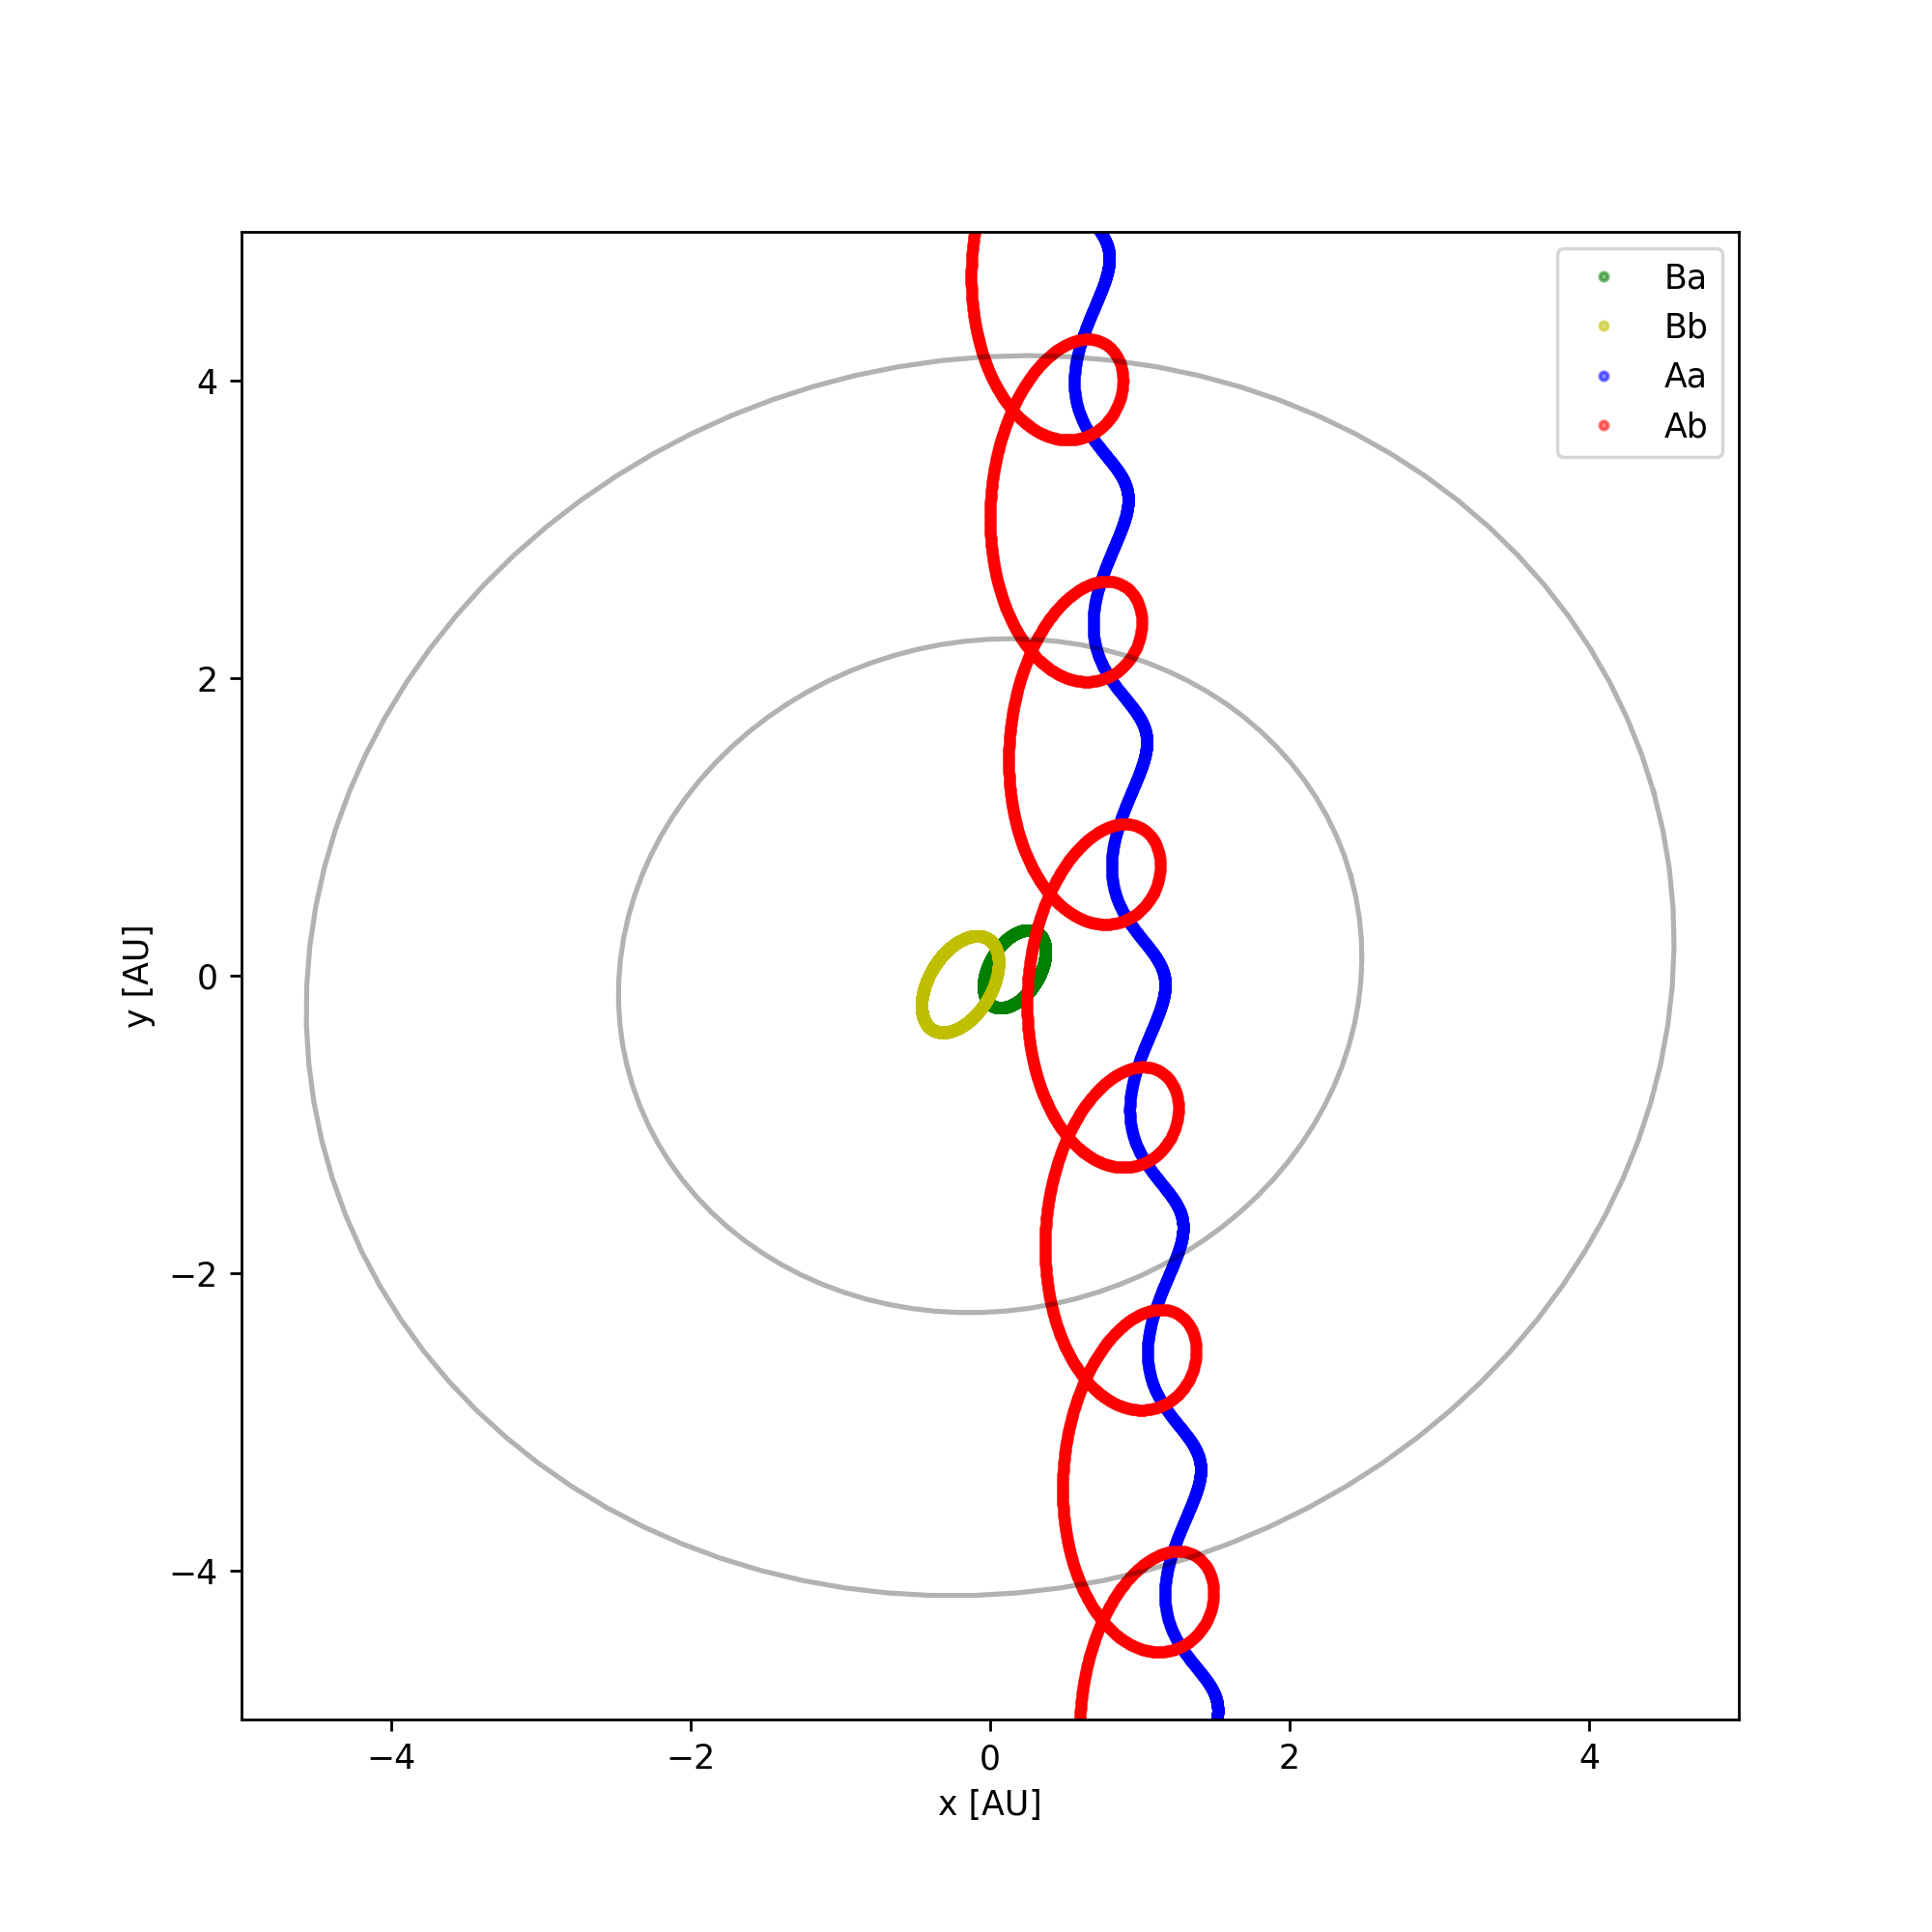

In [51]:
# Build disk

angles = np.linspace(0, 2*np.pi, 100)

x_outer = a_outer*np.cos(angles)
y_outer = b_outer*np.sin(angles)
z_outer = x_outer*np.tan(inc_disk)

x_inner = a_inner*np.cos(angles)
y_inner = b_inner*np.sin(angles)
z_inner = x_inner*np.tan(inc_disk)

# Rotate disk
x_o = x_outer*np.cos(pos_disk) - y_outer*np.sin(pos_disk)
y_o = x_outer*np.sin(pos_disk) + y_outer*np.cos(pos_disk)
x_i = x_inner*np.cos(pos_disk) - y_inner*np.sin(pos_disk)
y_i = x_inner*np.sin(pos_disk) + y_inner*np.cos(pos_disk)

x_inner = x_i
y_inner = y_i
x_outer = x_o
y_outer = y_o

# Make 2D plot
fig = plt.figure(1, figsize=(8,8))

plt.plot(x_Ba, y_Ba, 'g.', alpha = 0.5, markersize=5, label='Ba')
plt.plot(x_Bb, y_Bb, 'y.', alpha = 0.5, markersize=5, label='Bb')
plt.plot(x_Aa, y_Aa, 'b.', alpha = 0.5, markersize=5, label='Aa')
plt.plot(x_Ab, y_Ab, 'r.', alpha = 0.5, markersize=5, label='Ab')


plt.plot(x_inner, y_inner, 'k', alpha=0.3)
plt.plot(x_outer, y_outer, 'k', alpha=0.3)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend()


# # 3D Plot
# ax = fig.add_subplot(111, projection='3d')

# # Plot binary orbits relative to the  CoM of BaBb
# ax.plot(x_Aa, y_Aa, z_Aa, 'b.', alpha = 0.5, label='Aa', markersize=2)
# ax.plot(x_Ab, y_Ab, z_Ab, 'r.', alpha = 0.5, label='Ab', markersize=2)
# ax.plot(x_Ba, y_Ba, z_Ba, 'g.', alpha = 0.5, label='Ba', markersize=1)
# ax.plot(x_Bb, y_Bb, z_Bb, 'c.', alpha = 0.5, label='Bb', markersize=1)

# # Plot disk in 3D
# ax.plot(x_outer, y_outer, z_outer, 'k', alpha=0.3)
# ax.plot(x_inner, y_inner, z_inner, 'k', alpha=0.3)

# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# ax.legend()






In [52]:
# # THIS TAKES A WHILE TO RUN!!
# # ONLY RUN THIS CELL (AND THE ONE AFTER) IF YOU WANT TO SAVE EACH FRAME OF THE TRANSIT FOR A GIF/MOVIE

# fig_gif = plt.figure(2, figsize=(8,8))
# plt.plot(x_inner, y_inner, 'w', alpha=0.3, ls='--')
# plt.plot(x_outer, y_outer, 'w', alpha=0.3, ls='--')
# plt.xlim(-5,5)
# plt.ylim(-5,5)
# plt.xlabel('x [AU]')
# plt.ylabel('y [AU]')


# for i in range(1700,4300,2):
#     plt.plot(x_Ba[i], y_Ba[i], 'g.', markersize=3, figure=fig_gif)
#     plt.plot(x_Bb[i], y_Bb[i], 'y.', markersize=3, figure=fig_gif)
#     plt.plot(x_Aa[i], y_Aa[i], 'skyblue', marker='.', markersize=3, figure=fig_gif)
#     plt.plot(x_Ab[i], y_Ab[i], 'r.', alpha = 0.5, figure=fig_gif)
    
#     tp1, = plt.plot(x_Ba[i], y_Ba[i], 'darkgreen', marker='*', markersize=8, label='Ba', figure=fig_gif)
#     tp2, = plt.plot(x_Bb[i], y_Bb[i], 'gold', marker='*', markersize=8, label='Bb', figure=fig_gif)
#     tp3, = plt.plot(x_Aa[i], y_Aa[i], 'deepskyblue', marker='*', markersize=8, label='Aa', figure=fig_gif)
#     tp4, = plt.plot(x_Ab[i], y_Ab[i], 'firebrick', marker='*', markersize=8, label='Ab', figure=fig_gif)

#     plt.legend()    
#     ax = plt.gca()
#     ax.set_facecolor('black')
#     plt.savefig(f'transit_{i}.png')

#     tp1.remove()
#     tp2.remove()
#     tp3.remove()
#     tp4.remove()


In [53]:
# import imageio
# images = []
# for i in range(1700,4300,2):
#     images.append(imageio.imread(f'transit_{i}.png'))
# imageio.mimsave('transit.gif', images, fps=30)

<IPython.core.display.Javascript object>


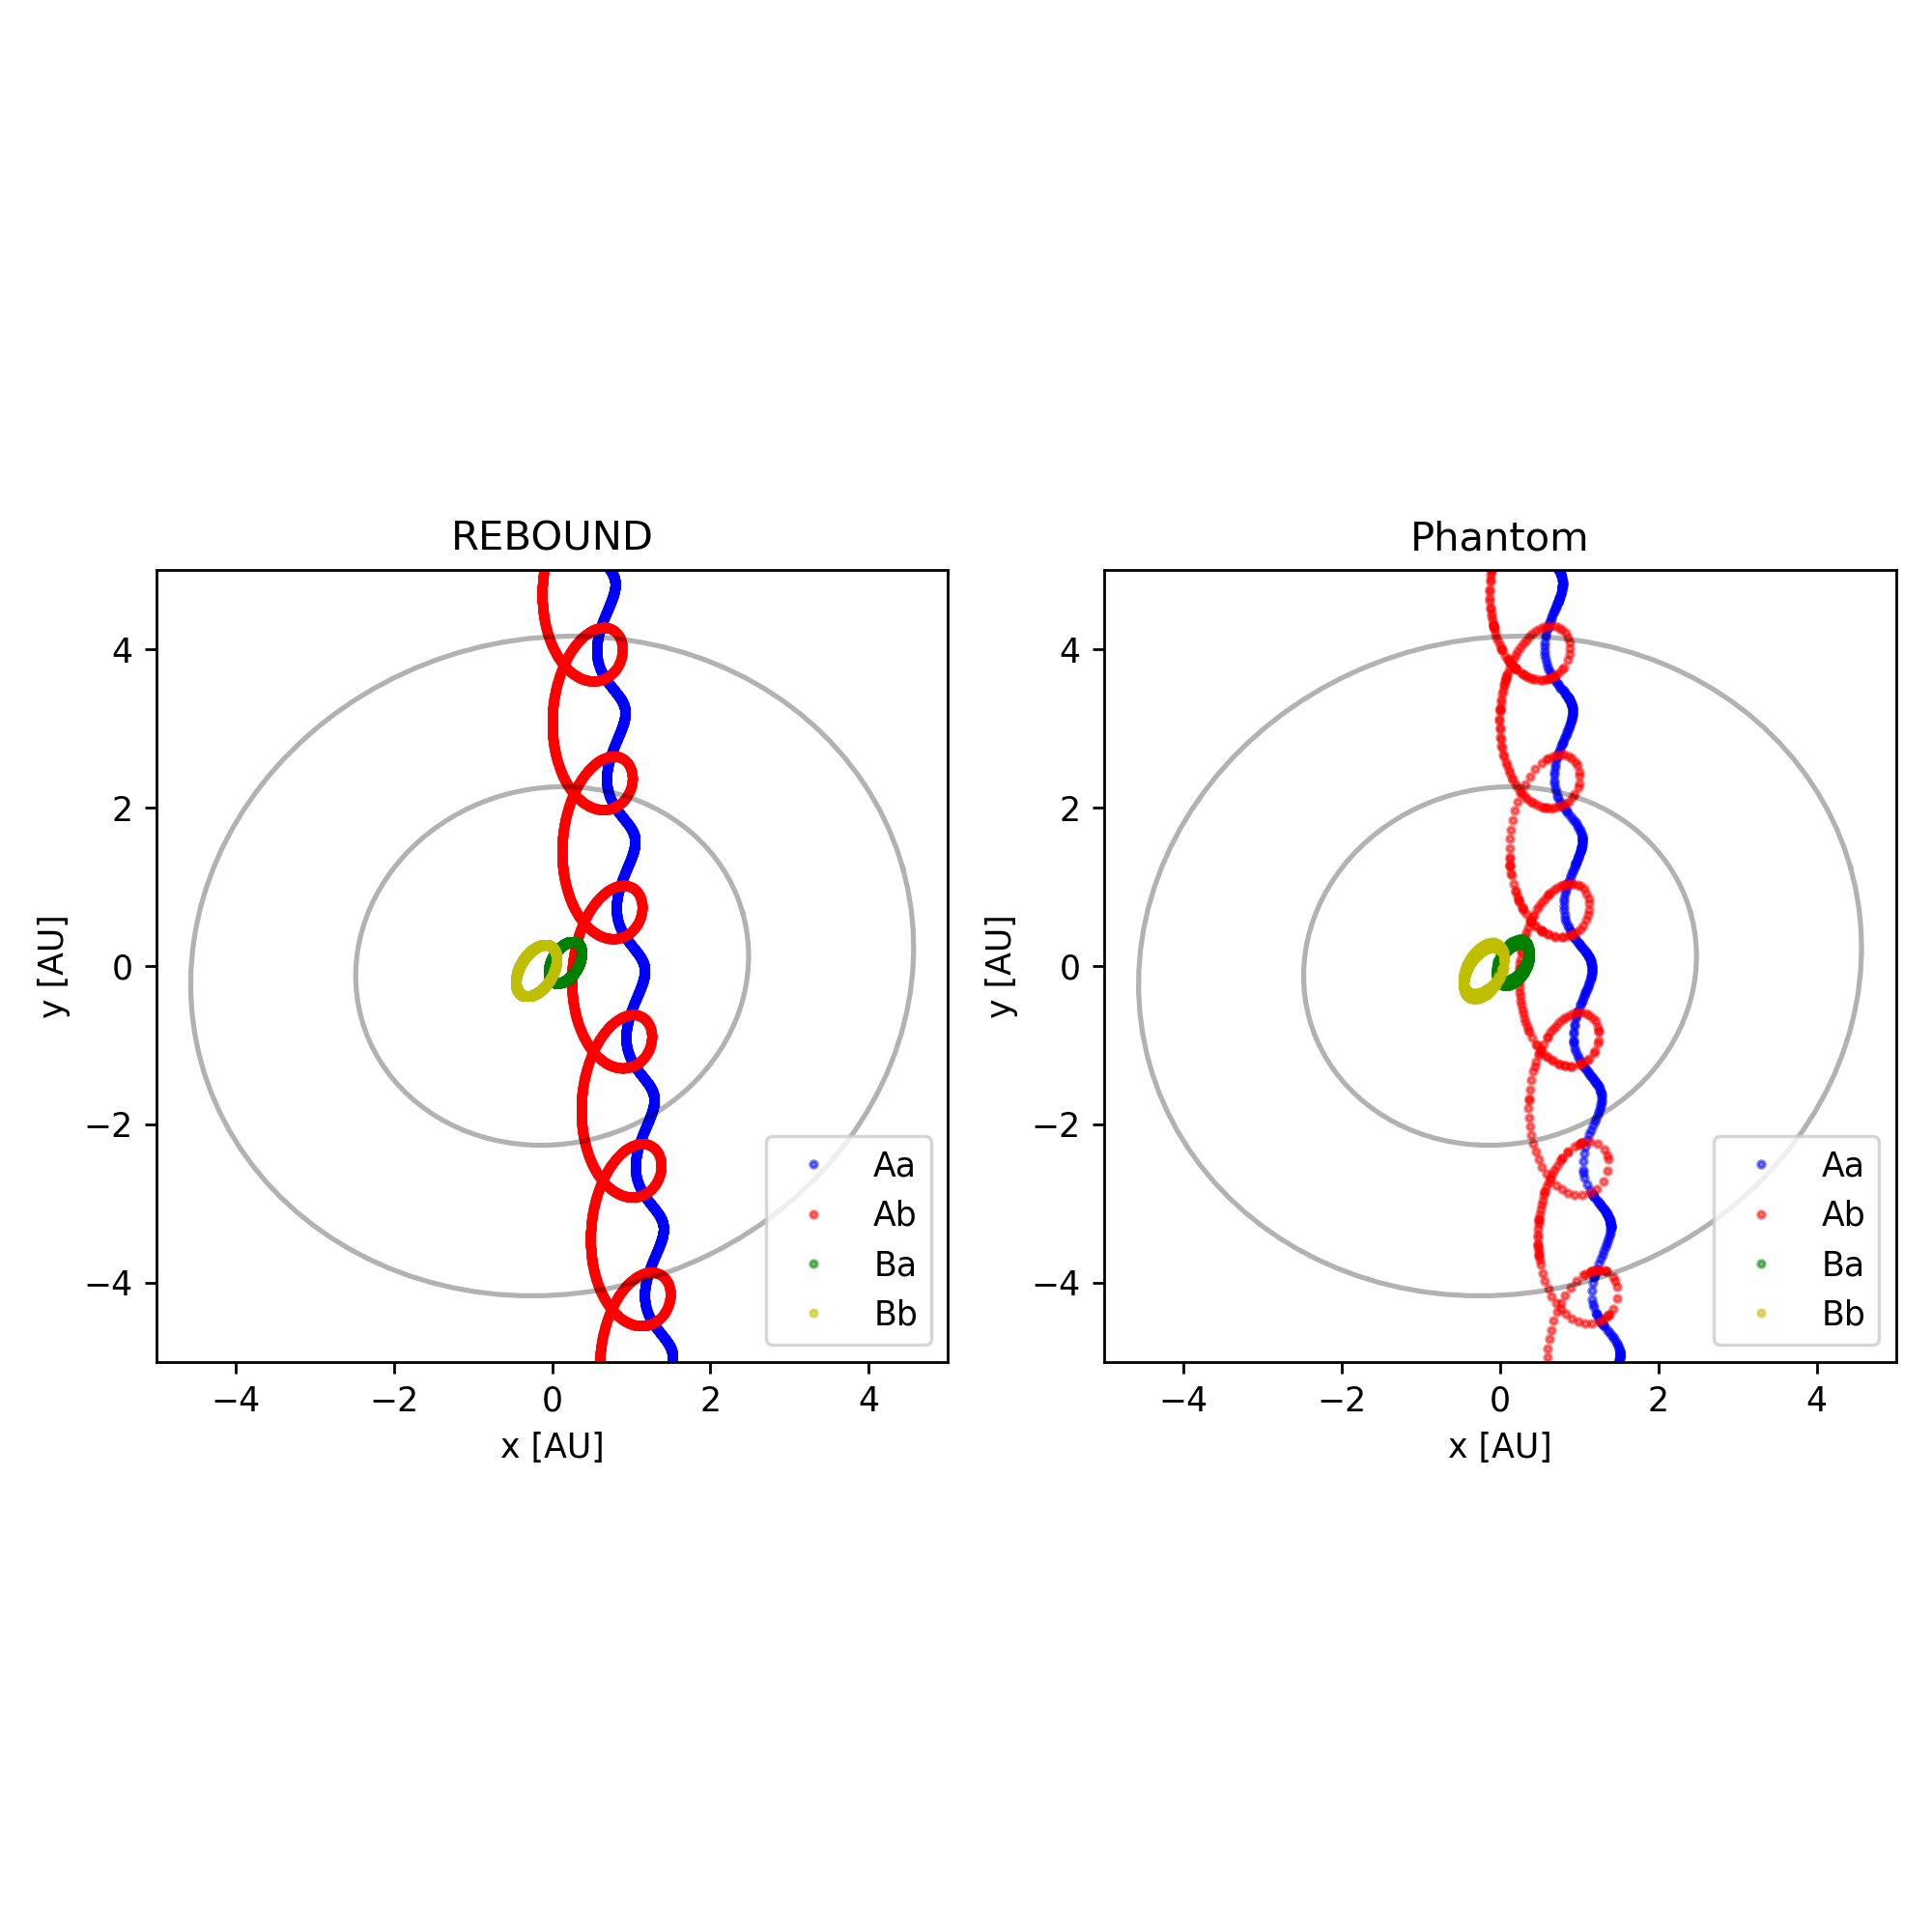

In [56]:
def merge_ev_files(sink, ev_files=1):
    data = pd.DataFrame()
    for file_number in range(1, ev_files+1):
        data_subset = pd.read_csv(
        f'discSink000{sink}N0{file_number}.ev', sep='\s+', skiprows=[0], engine='python', names=[str(i) for i in range(20)]
    )
        data = pd.concat([data, data_subset])
    
    return data


fig_ph, ax = plt.subplots(1, 2, figsize=(8,8))

# Ab
data1 = merge_ev_files(1)
x1 = np.array(data1['1'])
y1 = np.array(data1['2'])

# Bb
data2 = merge_ev_files(2)
x2 = np.array(data2['1'])
y2 = np.array(data2['2'])

# Aa
data3 = merge_ev_files(3)
x3 = np.array(data3['1'])
y3 = np.array(data3['2'])

# Ba
data4 = merge_ev_files(4)
x4 = np.array(data4['1'])
y4 = np.array(data4['2'])


# Shift everything to CoM ob B reference frame
com_B = (m_Bb*np.array([x2,y2]) + m_Ba*np.array([x4,y4]))/m_B
x1, y1 = np.array([x1,y1]) - com_B
x2, y2 = np.array([x2,y2]) - com_B
x3, y3 = np.array([x3,y3]) - com_B
x4, y4 = np.array([x4,y4]) - com_B

# Make plots for comparison (Phantom vs. REBOUND)

# Phantom data
ax[1].set_title('Phantom', fontsize=12)
ax[1].plot(x3, y3, 'b.', alpha = 0.5, markersize=4, label='Aa', figure=fig_ph)
ax[1].plot(x1, y1, 'r.', alpha = 0.5, markersize=4, label='Ab', figure=fig_ph)
ax[1].plot(x4, y4, 'g.', alpha = 0.5, markersize=4, label='Ba', figure=fig_ph)
ax[1].plot(x2, y2, 'y.', alpha = 0.5, markersize=4, label='Bb', figure=fig_ph)

ax[1].plot(x_inner, y_inner, 'k', alpha=0.3)
ax[1].plot(x_outer, y_outer, 'k', alpha=0.3)
ax[1].set_xlim(-5,5)
ax[1].set_ylim(-5,5)
ax[1].set_xlabel('x [AU]')
ax[1].set_ylabel('y [AU]')
ax[1].legend()
ax[1].set_aspect('equal', 'box')

# REBOUND data
ax[0].set_title('REBOUND', fontsize=12)
ax[0].plot(x_Aa, y_Aa, 'b.', alpha = 0.5, markersize=4, label='Aa', figure=fig_ph)
ax[0].plot(x_Ab, y_Ab, 'r.', alpha = 0.5, markersize=4, label='Ab', figure=fig_ph)
ax[0].plot(x_Ba, y_Ba, 'g.', alpha = 0.5, markersize=4, label='Ba', figure=fig_ph)
ax[0].plot(x_Bb, y_Bb, 'y.', alpha = 0.5, markersize=4, label='Bb', figure=fig_ph)


ax[0].plot(x_inner, y_inner, 'k', alpha=0.3)
ax[0].plot(x_outer, y_outer, 'k', alpha=0.3)
ax[0].set_xlim(-5,5)
ax[0].set_ylim(-5,5)
ax[0].set_xlabel('x [AU]')
ax[0].set_ylabel('y [AU]')
ax[0].legend()
ax[0].set_aspect('equal', 'box')
fig_ph.tight_layout()


fig_ph.tight_layout()


In [11]:
# fig_xv, ax_xv = plt.subplots(1, 2, figsize=(8,4))

# vx3 = np.array(data3['5'])
# vy3 = np.array(data3['6'])

# ax_xv[0].set_title('Positions', fontsize=12)
# ax_xv[1].set_title('Velocities', fontsize=12)
# ax[0].set_xlabel('t')
# ax[0].set_ylabel('Distance to origin')
# ax[1].set_xlabel('t')
# ax[1].set_ylabel('Velocity (relative to  origin)')


# for t  in range(1000):
    
#     Aa_pos_R = np.array(x_Aa[t], y_Aa[t])
#     Aa_dist_R = np.linalg.norm(Aa_pos_R)
#     ax_xv[0].plot(t, Aa_dist_R, 'g.')
    
#     Aa_pos_P = np.array(x3[t], y3[t])
#     Aa_dist_P = np.linalg.norm(Aa_pos_P)
#     ax_xv[0].plot(t, Aa_dist_P, 'r.')

#     Aa_vel_R = np.array(vx_Aa[t], vy_Aa[t])
#     Aa_speed_R = np.linalg.norm(Aa_vel_R)
#     ax_xv[1].plot(t, Aa_speed_R, 'g.')
    
#     Aa_vel_P = np.array(vx3[t], vy3[t])
#     Aa_speed_P = np.linalg.norm(Aa_vel_P)
#     ax_xv[1].plot(t, Aa_speed_P, 'r.')
    

